In [1]:
import os
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
import networkx as nx
import xarray as xr

from hydromt_sfincs import SfincsModel
from hydromt_sfincs import utils


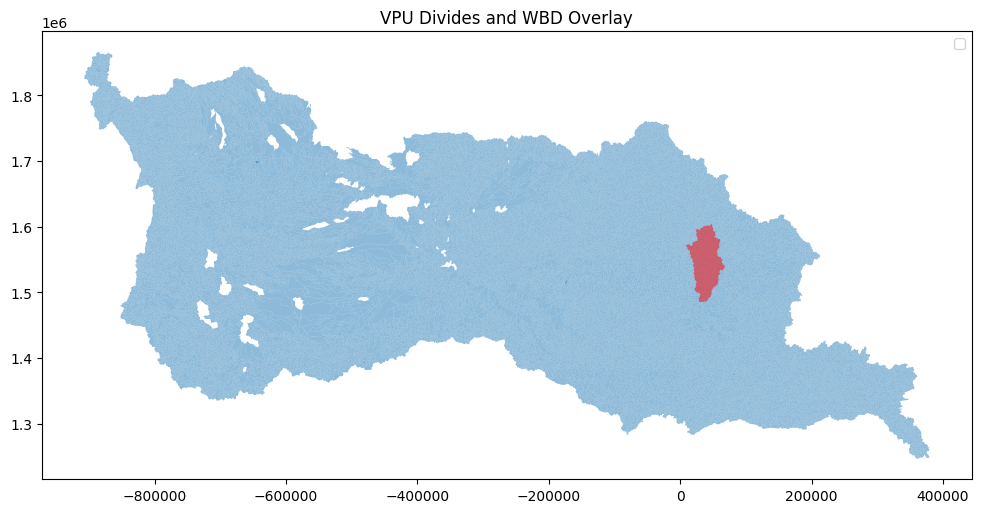

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
hf = gpd.read_file("../data/vpu_11.gpkg", layer="divides")
huc8 = gpd.read_file("output/flood_11070103/11070103/wbd.gpkg")

hf.plot(ax=ax, alpha=0.5, label='VPU Divides')
huc8.plot(ax=ax, color='red', alpha=0.5, label='WBD')

plt.legend()
plt.title('VPU Divides and WBD Overlay')
plt.show()


In [3]:
data_catalog_path = Path.cwd() / "../data/SFINCS/data_catalogs"
sfincs_model_path = Path.cwd() / "../data/SFINCS/ngwpc_data_huc8"
lynker_spatial_lib = str(data_catalog_path / "lynker_spatial/gridded_data.yaml")
# huc_6_dem = "/app/data/SFINCS/data_catalogs/huc6.yaml"
sf = SfincsModel(data_libs=[lynker_spatial_lib], root=str(sfincs_model_path), mode="w+")


In [4]:
import sys

current_dir = Path.cwd()
src_path = current_dir.parents[0]
sys.path.append(src_path.__str__())

from src.rise.utils import hydrofabric  # noqa: E402


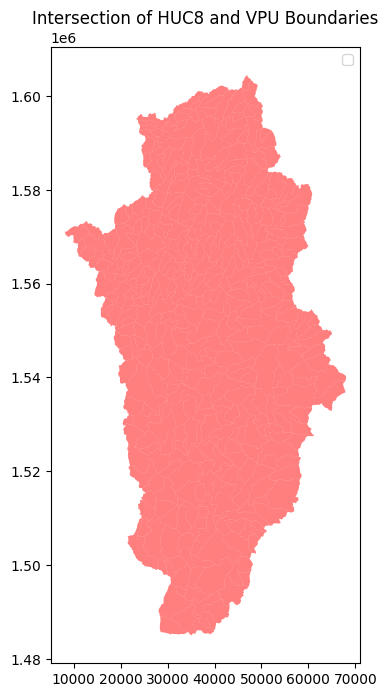

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt

divides = gpd.read_file("../data/vpu_11.gpkg", layer="divides")
intersection = gpd.overlay(divides, huc8, how='intersection')

fig, ax = plt.subplots(figsize=(12, 8))
intersection.plot(ax=ax, color='red', alpha=0.5, label='Intersection')
plt.legend()
plt.title('Intersection of HUC8 and VPU Boundaries')

plt.show()


In [6]:
sf.setup_grid_from_region(
    region = {'geom': intersection},
    res= 50,
    rotated=True,
    crs=intersection.crs  # NAD83 / Conus Albers
)
print(sf.config)


{'mmax': 1067, 'nmax': 2305, 'dx': 50, 'dy': 50, 'x0': 25951.0, 'y0': 1482591.0, 'rotation': 11.441, 'latitude': 0.0, 'tref': datetime.datetime(2010, 2, 1, 0, 0), 'tstart': datetime.datetime(2010, 2, 1, 0, 0), 'tstop': datetime.datetime(2010, 2, 2, 0, 0), 'tspinup': 60.0, 'dtout': 3600.0, 'dthisout': 600.0, 'dtrstout': 0.0, 'dtmaxout': 86400, 'trstout': -999.0, 'dtwnd': 1800.0, 'alpha': 0.5, 'theta': 1.0, 'huthresh': 0.01, 'manning': 0.04, 'manning_land': 0.04, 'manning_sea': 0.02, 'rgh_lev_land': 0.0, 'zsini': 0.0, 'qinf': 0.0, 'rhoa': 1.25, 'rhow': 1024.0, 'dtmax': 60.0, 'advection': 1, 'baro': 1, 'pavbnd': 0, 'gapres': 101200.0, 'stopdepth': 100.0, 'crsgeo': 0, 'btfilter': 60.0, 'viscosity': 1, 'inputformat': 'bin', 'outputformat': 'net', 'cdnrb': 3, 'cdwnd': [0.0, 28.0, 50.0], 'cdval': [0.001, 0.0025, 0.0015], 'epsg': 5070}


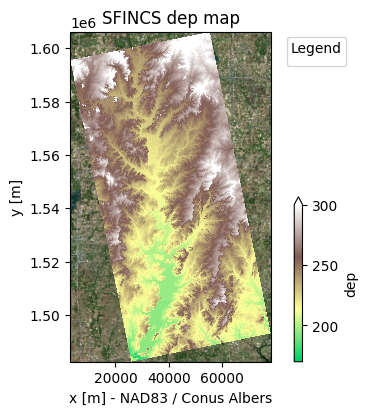

In [7]:
datasets_dep = [{"elevtn": "USGS_seamless_13", "zmin": 0.001}]
dep = sf.setup_dep(datasets_dep=datasets_dep)
_ = sf.plot_basemap(variable="dep", bmap="sat", zoomlevel=12)


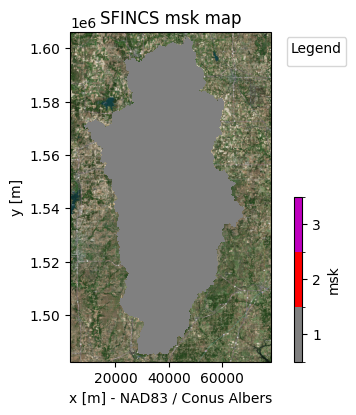

In [8]:
sf.setup_mask_active(include_mask=intersection,reset_mask=True)
_ = sf.plot_basemap(variable="msk", plot_bounds=True, bmap="sat", zoomlevel=12)


In [9]:
file_path = "../data/vpu_11.gpkg"
end_node = intersection.sort_values("tot_drainage_areasqkm" ,ascending=True).iloc[-1]["toid"]
nexus = gpd.read_file(file_path, layer="nexus")
downstream_nexus = nexus[nexus["id"] == end_node]


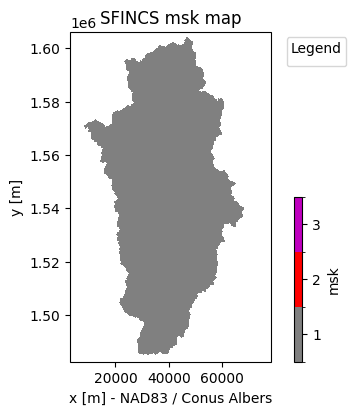

In [10]:
sf.setup_mask_bounds(btype="waterlevel", include_mask=downstream_nexus, reset_bounds=True)
fig, ax = sf.plot_basemap(variable="msk", plot_bounds=True, zoomlevel=12)


In [11]:

flowlines = gpd.read_file(file_path, layer="flowpaths")
# flowpath_attributes = hydrofabric.get_layer(file_path, layer="flowpath-attributes")

# G = hydrofabric.get_hydrofabric_vpu_graph(nexus, flowlines)

# start_node = "nex-2185393"
# end_node = "nex-2185398" 
# path = nx.shortest_path(G, start_node, end_node)

# mask_flowlines = flowlines["id"].isin(path) | flowlines["toid"].isin(path) & (flowlines["toid"] != end_node)
# mask_nexus = nexus["id"].isin(path) | nexus["toid"].isin(path) & (nexus["id"] != end_node)
# mask_divides = divides["id"].isin(path) | divides["toid"].isin(path)
# mask_attributes = flowpath_attributes["id"].isin(path)

# _subset_nexus = nexus[mask_nexus]
# _subset_flowlines = flowlines[mask_flowlines]
# downstream_nexus = nexus[nexus["id"] == end_node]

# domain_nexus = nexus[
#     nexus["toid"].isin(_subset_flowlines["id"]) | 
#     (nexus["id"].isin(path) | nexus["toid"].isin(path) & (nexus["id"] != end_node))
# ]
# domain_flowlines = flowlines[flowlines["toid"].isin(domain_nexus["id"])]
# domain_divides = divides[mask_divides]

# _subset_nexus.to_file(data_path / "domain_nexus.gpkg", driver='GPKG')
# _subset_flowlines.to_file(data_path / "domain_flowlines.gpkg", driver='GPKG')
# _subset_divides.to_file(data_path / "domain_divides.gpkg", driver='GPKG')
# downstream_nexus.to_file(data_path / "downstream_nexus.gpkg", driver='GPKG')


In [26]:
sf.setup_river_inflow(
    rivers=flowlines, 
    buffer=0.9,
    river_width=10,
    keep_rivers_geom=True
)
# print(sf.config)
fig, ax = sf.plot_basemap(variable="dep", plot_bounds=False, bmap="sat", zoomlevel=12)


Error in callback <function flush_figures at 0x7da35fba30a0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [13]:
sfincs_points = sf.forcing['dis'].vector.to_gdf()
nexus = gpd.read_file(file_path, layer="network")
joined_flowlines = gpd.sjoin_nearest(sfincs_points, flowlines, how='left')

network = gpd.read_file(file_path, layer="network")
domain_network = network[network["id"].isin(joined_flowlines["id"])]
all_comids = np.array([list(set([x for _, group in domain_network.groupby("id") 
              for x in group["hf_id"].values.astype(int).tolist()]))])

np.save(Path.cwd() / "../data/NWM/coffeyville_feature_ids_huc_8.npy", all_comids)
output_dir = Path.cwd() / "../data/NWM/nwm30_retrospective"


In [19]:
! python ../tools/retrospective_nwm.py --feature_id_file ../data/NWM/coffeyville_feature_ids_huc_8.npy --date-range 2019-05-20 2019-06-03  --output_file ../data/NWM/huc_8_retro


In [20]:
flow_data = xr.open_zarr("../data/NWM/retro")
time_range = flow_data.time.values
flow_data


<xarray.Dataset> Size: 195kB
Dimensions:     (feature_id: 71, time: 337)
Coordinates:
  * feature_id  (feature_id) int64 568B 21796353 21796611 ... 21796347 21796863
  * time        (time) datetime64[ns] 3kB 2019-05-20 ... 2019-06-03
Data variables:
    streamflow  (time, feature_id) float64 191kB dask.array<chunksize=(241, 71), meta=np.ndarray>

In [25]:
all_comids


array([[20943936, 21518114, 21518108, 20943782, 21518086, 20943752,
        21518088, 21518118, 21518094, 21518096, 20943764, 21518100,
        21518102, 20943768, 21518106, 20943772, 21518110]])

In [21]:
flows_arr = np.zeros((len(time_range), sf.forcing['dis'].shape[1]))
for idx, row in joined_flowlines.iterrows():
    _id = row["id"]
    inflow_segments = domain_network[domain_network["id"] == _id]
    group_ids = inflow_segments["hf_id"].values.astype(int)
    subset_flow_data = flow_data.sel(feature_id=group_ids).streamflow.values
    flows_arr[:, idx-1] = np.max(subset_flow_data, axis=1)


KeyError: "not all values found in index 'feature_id'"

In [22]:
group_ids


array([20943752, 20943764, 20943768, 20943772, 20943782, 20943936])

In [24]:
flow_data.feature_id


<xarray.DataArray 'feature_id' (feature_id: 71)> Size: 568B
array([21796353, 21796611, 21796743, 21796871, 21797001, 21797007, 21796751,
       21796367, 21796369, 21797011, 21797647, 21797009, 21796885, 21797651,
       21797655, 21797017, 21797401, 21797019, 21796379, 21796381, 21796891,
       21796895, 21797145, 21797663, 21797665, 21796775, 21796777, 21796351,
       21797035, 21797421, 21796397, 21796781, 21796913, 21796275, 21796277,
       21796789, 21796917, 21797753, 21796411, 21797143, 21796413, 21796799,
       21796927, 21797755, 21797061, 21796295, 21797063, 21796297, 21796935,
       21797453, 21797069, 21797455, 21797071, 21796817, 21797073, 21796819,
       21796951, 21796319, 21796959, 21796963, 21797349, 21796581, 21797735,
       21796967, 21797357, 21796847, 21796339, 21796855, 21796857, 21796347,
       21796863])
Coordinates:
  * feature_id  (feature_id) int64 568B 21796353 21796611 ... 21796347 21796863
Attributes:
    cf_role:    timeseries_id
    comment:    NHDPlusv2 ComIDs within CONUS, arbitrary Reach IDs outside of...
    long_name:  Reach ID